## Empirical Bayes experiments - different datasets and prior weightings

### Step 0: packages

In [1]:
# test modification

library(data.table)
library(tidyverse)
library(distr)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()

Loading required package: startupmsg

Utilities for Start-Up Messages (version 0.9.6)

For more information see ?"startupmsg", NEWS("startupmsg")


Loading required pa

### Step 1: load in the data and split it into train and test sets

In [2]:
# raw_df = read.csv("data/Gift_Cards.csv", header = FALSE, col.names=c("item", "user", "rating", "timestamp"))
raw_df = read.csv("data/Video_Games_raw.csv", header = FALSE, col.names=c("item", "user", "rating", "timestamp"))
# raw_df = read.csv("data/Prime_Pantry.csv", header = FALSE, col.names=c("item", "user", "rating", "timestamp"))
head(raw_df)

set.seed(1729)

df <- raw_df %>% 
  select(c("item", "rating"))

counts <- count(df, item) %>%
  filter(n > 20)

df = merge(counts, df, by="item")
in.train = sample(unique(df$item), size = 0.6*length(unique(df$item)))
df.train = filter(df, item %in% in.train)
df.test = filter(df, !item %in% in.train)

,item,user,rating,timestamp
,<chr>,<chr>,<dbl>,<int>
1,0439381673,A21ROB4YDOZA5P,1,1402272000
2,0439381673,A3TNZ2Q5E7HTHD,3,1399680000
3,0439381673,A1OKRM3QFEATQO,4,1391731200
4,0439381673,A2XO1JFCNEYV3T,1,1391731200
5,0439381673,A19WLPIRHD15TH,4,1389830400
6,0439381673,A1TLA7XXSZMTS7,5,1389052800


In [3]:
nrow(raw_df)

[1] 2565349

### Step 2: Train the EB model (categorical with Dirichlet prior)

In [4]:
prior_df <- dcast(setDT(df.train), item ~ rating, fun.aggregate = length)

colnames(prior_df) <- c("item", "n1", "n2", "n3", "n4", "n5")

prior_df$n = prior_df$n1 + prior_df$n2 + prior_df$n3 + prior_df$n4 + prior_df$n5

prior_df <- filter(prior_df, n > 20)

# remove all columns with a 0 count for one category
prior_df  <- transmute(prior_df, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n) %>% 
  filter(n1 != 0 & n2 != 0 & n3 != 0 & n4 != 0 & n5 != 0)

log_p <- summarize(prior_df, summarize(prior_df, n1 = sum(log(n1)), n2 = sum(log(n2)), n3 = sum(log(n3)), n4=sum(log(n4)), n5=sum(log(n5))))
log_p <- as.numeric(log_p[1,])

print(log_p)
# gift cards log-p: -558.81647 -798.35765 -708.34644 -518.60578  -36.76743
# video games log-p: -19110.579 -23947.009 -20340.458 -15104.914  -5944.121
# prime pantry log-p: -5113.2916 -5570.4004 -4816.4874 -3816.7264  -770.3125

N <- nrow(prior_df)

# start from a totally uninformed prior
alphas = c(1,1,1,1,1)

# actual training function

fp_step <- function(alphas, log_p, N) {
  return(igamma(rep(digamma(sum(alphas)), 5) + log_p/N))
}

[1] -19110.579 -23947.009 -20340.458 -15104.914  -5944.121


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



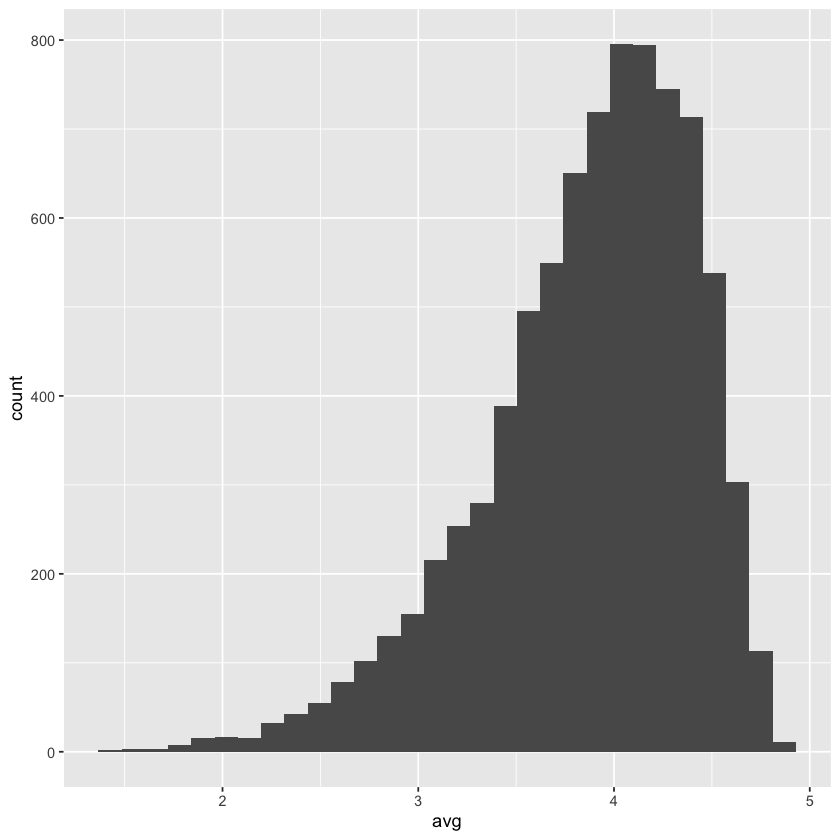

In [5]:
prior_df <- mutate(prior_df, avg = n1 + 2*n2 + 3*n3 + 4*n4 + 5*n5)
ggplot(prior_df) + geom_histogram(aes(x=avg))

In [6]:
# this step must be repeated many times.
# gift card alphas: 18.41389   4.77803   7.56642  21.55294 309.98082
# video game alphas: 2.026083 1.318121 1.806632 3.009980 8.200924
# prime pantry alphas: 2.360188  1.927949  2.705008  4.389483 22.445298
alphas <- fp_step(alphas, log_p, N)
b = sum(alphas)
print(alphas)

[1] 0.8678302 0.6387422 0.7986619 1.1673404 2.6695574


In [7]:
# check if stability achieved

for (i in c(1:100)) {
    alphas <- fp_step(alphas,log_p,N)
}
print(alphas)

[1] 2.026079 1.318119 1.806630 3.009975 8.200909


In [8]:
alphas_b = alphas/sum(alphas)
print(alphas_b)

[1] 0.12383053 0.08056118 0.11041813 0.18396454 0.50122561


### Step 3: Prepare the various testing methods

In [9]:
temp = filter(raw_df, item %in% df.test$item)
df.test <- merge(counts, temp, by="item")

df.test <- filter(df.test, n >= 100) %>%
  group_by(item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_head(n=100)

#split test set in half
df.test_learn = group_by(df.test, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_head(n=50)
df.test_eval = group_by(df.test, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_tail(n=50)

# set up evaluation dataset for evaluating
df.test_eval <- dcast(setDT(df.test_eval), item ~ rating, fun.aggregate = length) %>% arrange(item)
colnames(df.test_eval) <- c("item", "n1", "n2", "n3", "n4", "n5")
df.test_eval$n = df.test_eval$"n1" + df.test_eval$"n2" + df.test_eval$"n3" + df.test_eval$"n4" + df.test_eval$"n5"
df.test_eval <- transmute(df.test_eval, item=item, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)

num_eval_products = nrow(df.test_eval)

#### Step 3.1 - Over-time test of EB compared with frequentist

In [10]:
# start training and checking performance at each step
items = unique(df.test_learn$item)

mses_f = tibble(items)
mses_b = tibble(items)
kls_f = tibble(items)
kls_b = tibble(items)
avg_f = tibble(items)
avg_b = tibble(items)

for (i in c(1:50)) {
  df.test_learn_subset = group_by(df.test_learn, item) %>%
    arrange(timestamp, .by_group = TRUE) %>%
    slice_head(n=i)

  df.test_learn_subset <- dcast(setDT(df.test_learn_subset), item ~ rating, fun.aggregate = length, drop=FALSE) %>% arrange(item)
  
  # adding missing columns
  for (j in setdiff(c("item", "1", "2", "3", "4", "5"), colnames(df.test_learn_subset))) {
    df.test_learn_subset[[j]] <- rep(0, num_eval_products)
  }
  df.test_learn_subset <- df.test_learn_subset[,c("item", "1", "2", "3", "4", "5")]
  
  colnames(df.test_learn_subset) <- c("item", "n1", "n2", "n3", "n4", "n5")
  df.test_learn_subset$n = df.test_learn_subset$"n1" + df.test_learn_subset$"n2" + df.test_learn_subset$"n3" + df.test_learn_subset$"n4" + df.test_learn_subset$"n5"

  df.test_learn_f <- transmute(df.test_learn_subset, item=item, avg = (n1+n2*2+n3*3+n4*4+n5*5)/n, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)
  df.test_learn_b <- mutate(df.test_learn_subset, item=item, b1 = n1 + alphas[1], b2 = n2 + alphas[2], b3 = n3 + alphas[3],
         b4 = n4 + alphas[4], b5 = n5 + alphas[5], b = n + sum(alphas))
  df.test_learn_b <- transmute(df.test_learn_b, item=item, avg = (b1+b2*2+b3*3+b4*4+b5*5)/n, b1 = (b1-1) / (b-5), b2 = (b2-1) / (b-5), b3 = (b3-1) / (b-5), b4 = (b4-1) / (b-5), b5 = (b5-1) / (b-5))
    
  df.test_learn_f <- df.test_learn_f %>% select(-c(item, avg))
  df.test_learn_b <- df.test_learn_b %>% select(-c(item, avg))
    
  df.test_eval_modified <- select(df.test_eval, -c(item))

  f_mse = rowSums((df.test_learn_f - df.test_eval_modified)^2)
  b_mse = rowSums((df.test_learn_b - df.test_eval_modified)^2)
  f_kl = rowSums(df.test_eval_modified*log(df.test_eval_modified/df.test_learn_f), na.rm = TRUE)
  f_kl[!is.finite(f_kl)] = 1
  b_kl = rowSums(df.test_eval_modified*log(df.test_eval_modified/df.test_learn_b), na.rm = TRUE)
  b_kl[!is.finite(b_kl)] = 1
    
  f_av = ((df.test_learn_f$n1 + 2*df.test_learn_f$n2 + 3*df.test_learn_f$n3 + 4*df.test_learn_f$n4 + 5*df.test_learn_f$n5)
                 - (df.test_eval_modified$n1 + 2*df.test_eval_modified$n2 + 3*df.test_eval_modified$n3 + 4*df.test_eval_modified$n4 + 5*df.test_eval_modified$n5))^2
  b_av = ((df.test_learn_b$b1 + 2*df.test_learn_b$b2 + 3*df.test_learn_b$b3 + 4*df.test_learn_b$b4 + 5*df.test_learn_b$b5)
                 - (df.test_eval_modified$n1 + 2*df.test_eval_modified$n2 + 3*df.test_eval_modified$n3 + 4*df.test_eval_modified$n4 + 5*df.test_eval_modified$n5))^2
  
  mses_f[[i]] = f_mse
  mses_b[[i]] = b_mse
  kls_f[[i]] = f_kl
  kls_b[[i]] = b_kl
  avg_f[[i]] = f_av
  avg_b[[i]] = b_av

}

mses_f = tibble(val = colSums(mses_f) / num_eval_products, method = "freq", idx=c(1:length(mses_f)))
mses_b = tibble(val = colSums(mses_b) / num_eval_products, method = "eb", idx=c(1:length(mses_b)))
kls_f = tibble(val = colSums(kls_f) / num_eval_products, method = "freq", idx=c(1:length(kls_f)))
kls_b = tibble(val = colSums(kls_b) / num_eval_products, method = "eb", idx=c(1:length(kls_b)))
avg_f = tibble(val = colSums(avg_f) / num_eval_products, method = "freq", idx=c(1:length(avg_f)))
avg_b = tibble(val = colSums(avg_b) / num_eval_products, method = "eb", idx=c(1:length(avg_b)))

mses = rbind(mses_f,mses_b)
kls = rbind(kls_f,kls_b)
avgs = rbind(avg_f,avg_b)

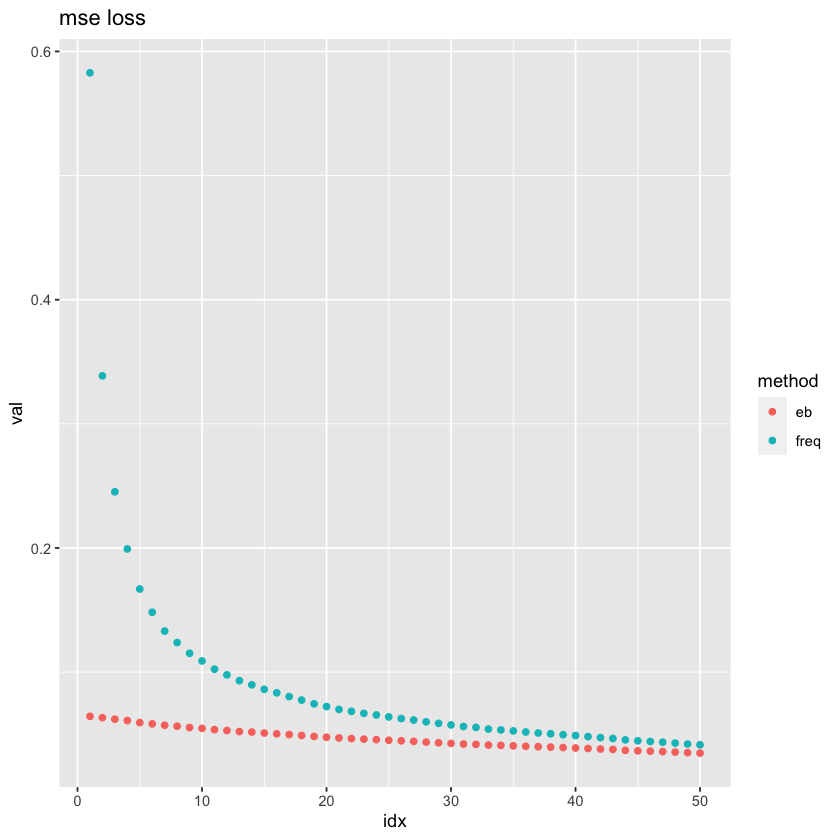

In [11]:
# Plot MSE loss

ggplot(mses, aes(x=idx, y=val, color=method)) +
  geom_point() +
  ggtitle("mse loss")

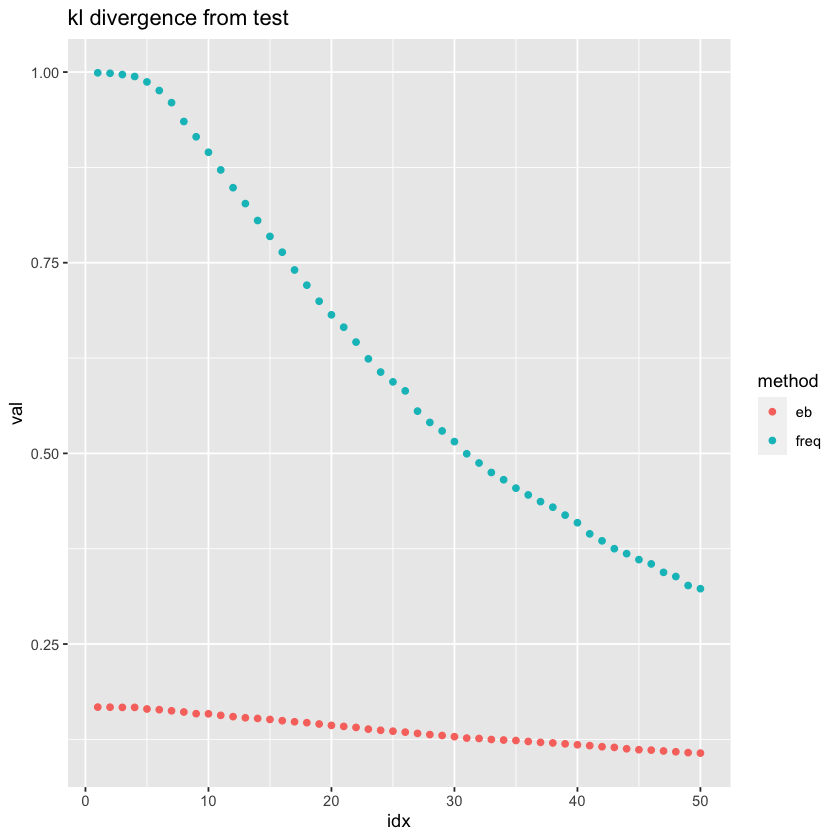

In [12]:
# Plot kl divergence

ggplot(kls, aes(x=idx, y=val, color=method)) +
  geom_point() +
  ggtitle("kl divergence from test")

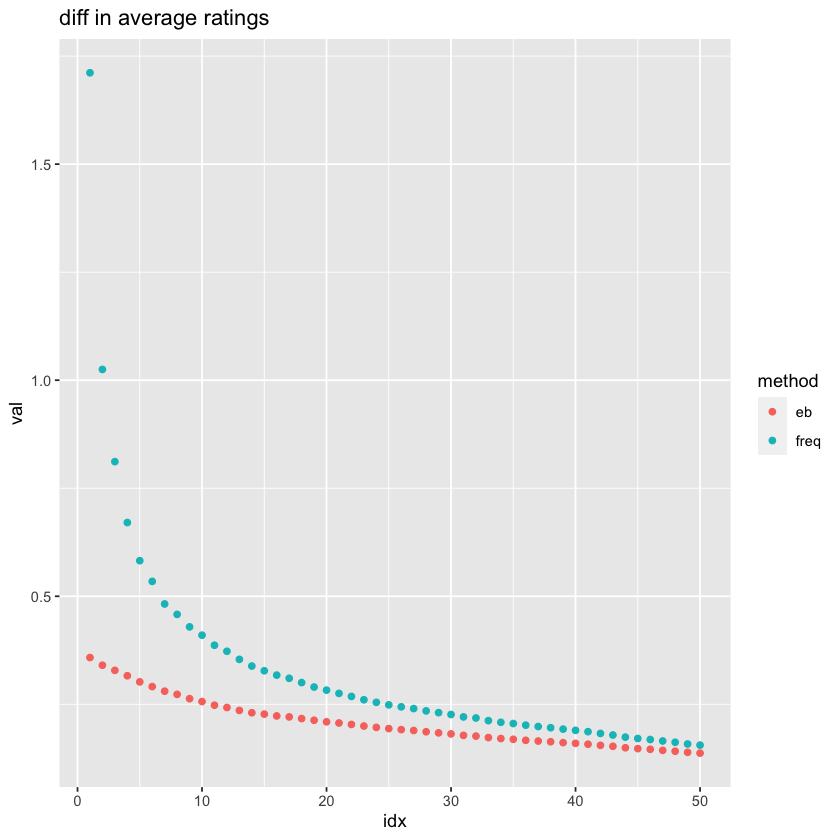

In [13]:
# Plot loss in calculating average

ggplot(avgs, aes(x=idx, y=val, color=method)) +
  geom_point() +
  ggtitle("diff in average ratings")

#### Step 3.2 Facet grid of MSE loss over train sample stratified by average rating

In [14]:
test_learn_agg <- dcast(setDT(df.test), item ~ rating, fun.aggregate = length)
colnames(test_learn_agg) <- c('item', 'n1', 'n2', 'n3', 'n4', 'n5')
test_learn_agg <- test_learn_agg %>% mutate(n = n1 + n2 + n3 + n4 + n5)
test_learn_agg <- transmute(test_learn_agg, item=item, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)

In [15]:
test_subset = test_learn_agg %>% mutate(avg = (n1+2*n2+3*n3+4*n4+5*n5))

In [16]:
head(test_subset)

item,n1,n2,n3,n4,n5,avg
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6050036071,0.15,0.06,0.09,0.20,0.50,3.84
9625990674,0.02,0.03,0.10,0.22,0.63,4.41
9629971372,0.26,0.05,0.10,0.15,0.44,3.46
9867299434,0.17,0.07,0.10,0.21,0.45,3.70
B00000DMAR,0.09,0.01,0.05,0.12,0.73,4.39
B00000DMB3,0.00,0.01,0.02,0.05,0.92,4.88


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



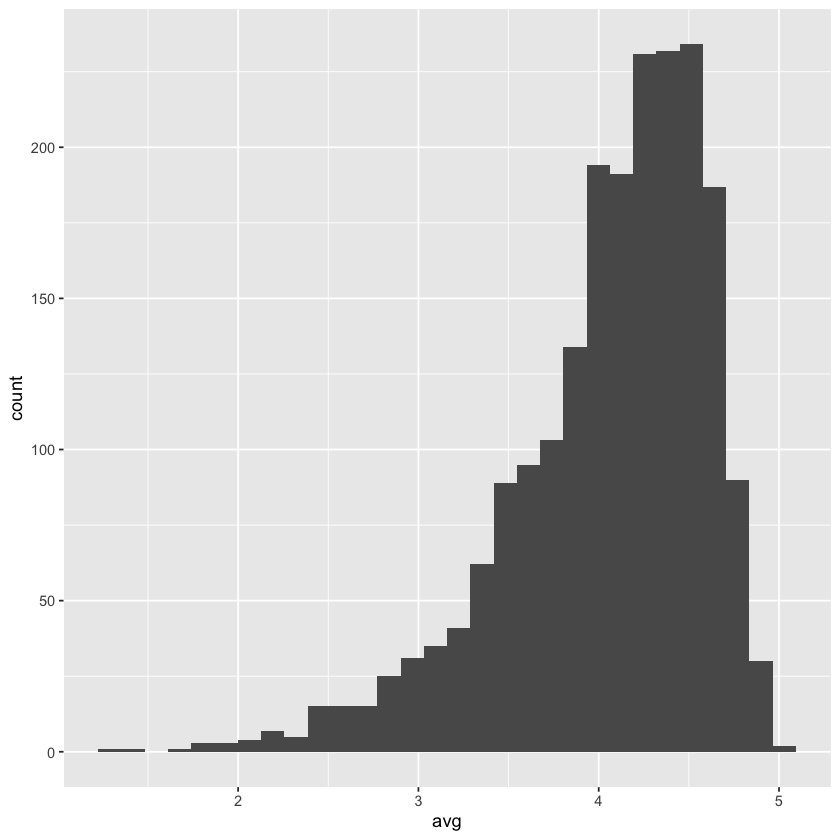

In [17]:
ggplot(test_subset, aes(x=avg)) +
    geom_histogram()

In [18]:
set.seed(1729)

num_prods = 20

test_subset_1 <- test_subset %>% filter(!duplicated(item)) %>% filter(avg <= 2) 
test_subset_1 <- test_subset_1 %>% sample_n(min(num_prods, nrow(test_subset_1))) 
test_subset_2 <- test_subset %>% filter(!duplicated(item)) %>% filter(avg <= 3, avg > 2) 
test_subset_2 <- test_subset_2 %>% sample_n(min(num_prods, nrow(test_subset_2)))
test_subset_3 <- test_subset %>% filter(!duplicated(item)) %>% filter(avg <= 4, avg > 3) 
test_subset_3 <- test_subset_3 %>% sample_n(min(num_prods, nrow(test_subset_3)))
test_subset_4 <- test_subset %>% filter(!duplicated(item)) %>% filter(avg > 4) 
test_subset_4 <- test_subset_4 %>% sample_n(min(num_prods, nrow(test_subset_4)))

# this is the list of items, along with their average score, that we will test

test_subset <- rbind(test_subset_1, test_subset_2, test_subset_3, test_subset_4)
print(nrow(test_subset))

[1] 69


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



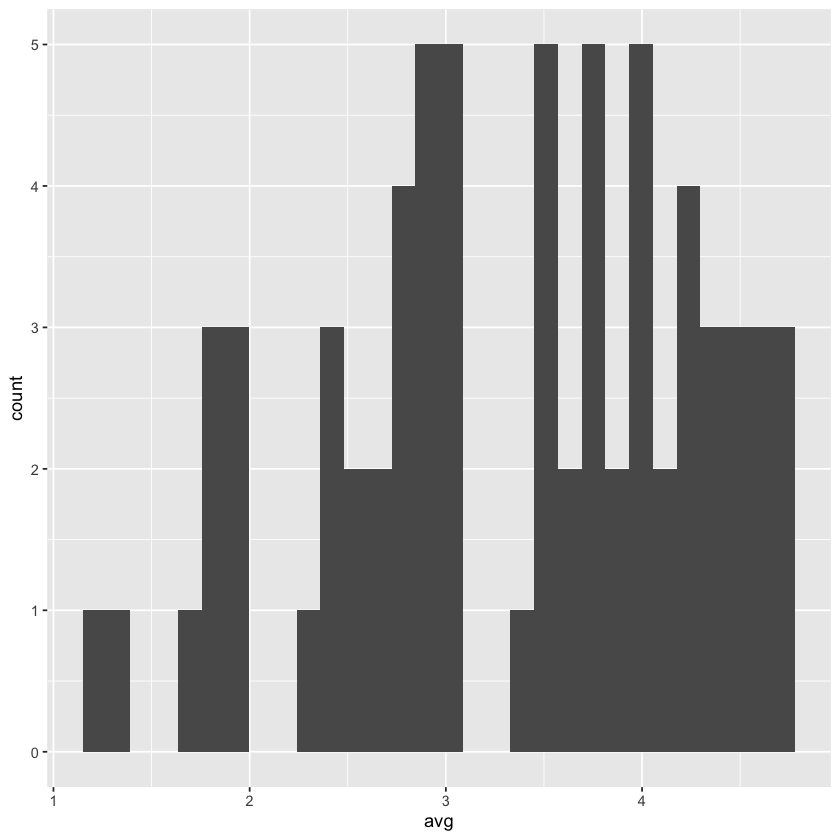

In [19]:
ggplot(test_subset, aes(x=avg)) +
    geom_histogram()

In [20]:
results_df = data.frame(matrix(ncol=5,nrow=0))

for (i in c(10, 20, 30, 40, 50)) {
  df.test_learn_subset = group_by(df.test_learn, item) %>%
    filter(item %in% test_subset$item) %>%
    arrange(timestamp, .by_group = TRUE) %>%
    slice_head(n=i)
    
  df.test_learn_subset <- dcast(setDT(df.test_learn_subset), item ~ rating, fun.aggregate = length, drop=FALSE) %>% arrange(item)
  
  # adding missing columns
  for (j in setdiff(c("item", "1", "2", "3", "4", "5"), colnames(df.test_learn_subset))) {
    df.test_learn_subset[[j]] <- rep(0, num_eval_products)
  }
  df.test_learn_subset <- df.test_learn_subset[,c("item", "1", "2", "3", "4", "5")]
    
  colnames(df.test_learn_subset) <- c("item", "n1", "n2", "n3", "n4", "n5")
  df.test_learn_subset$n = df.test_learn_subset$"n1" + df.test_learn_subset$"n2" + df.test_learn_subset$"n3" + df.test_learn_subset$"n4" + df.test_learn_subset$"n5"
    
  df.test_learn_f <- transmute(df.test_learn_subset, item=item, avg = (n1+n2*2+n3*3+n4*4+n5*5)/n, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)
  df.test_learn_b <- mutate(df.test_learn_subset, item=item, b1 = n1 + alphas[1], b2 = n2 + alphas[2], b3 = n3 + alphas[3],
         b4 = n4 + alphas[4], b5 = n5 + alphas[5], b = n + sum(alphas))
  df.test_learn_b <- transmute(df.test_learn_b, item=item, avg = (b1+b2*2+b3*3+b4*4+b5*5)/n, b1 = b1 / b, b2 = b2 / b, b3 = b3 / b, b4 = b4 / b, b5 = b5 / b)
    
  for (id in unique(test_subset$item)) {
      dist_b = filter(df.test_learn_b, item==id) %>% select(c(b1, b2, b3, b4, b5))
      dist_f = filter(df.test_learn_f, item==id) %>% select(c(n1, n2, n3, n4, n5))
      av = filter(test_subset, item==id)$avg
      dist_eval = filter(df.test_eval, item==id) %>% select(c(n1, n2, n3, n4, n5))
      
      to_add = c(id, sqrt(sum((dist_eval-dist_b)^2)), drop(av), i, 'eb')
      
      results_df <- rbind(results_df, to_add)
      
      to_add = c(id, sqrt(sum((dist_eval-dist_f)^2)), drop(av), i, 'freq')
      
      results_df <- rbind(results_df, to_add)
      
      to_add = c(id, sqrt(sum((dist_eval-alphas_b)^2)), drop(av), i, 'baseline')
      
      results_df <- rbind(results_df, to_add)
      
  }

}

colnames(results_df) <- c('item', 'dist', 'avg', 'num_train', 'method')

In [21]:
results_df$dist <- as.numeric(results_df$dist)
results_df$avg <- as.numeric(results_df$avg)

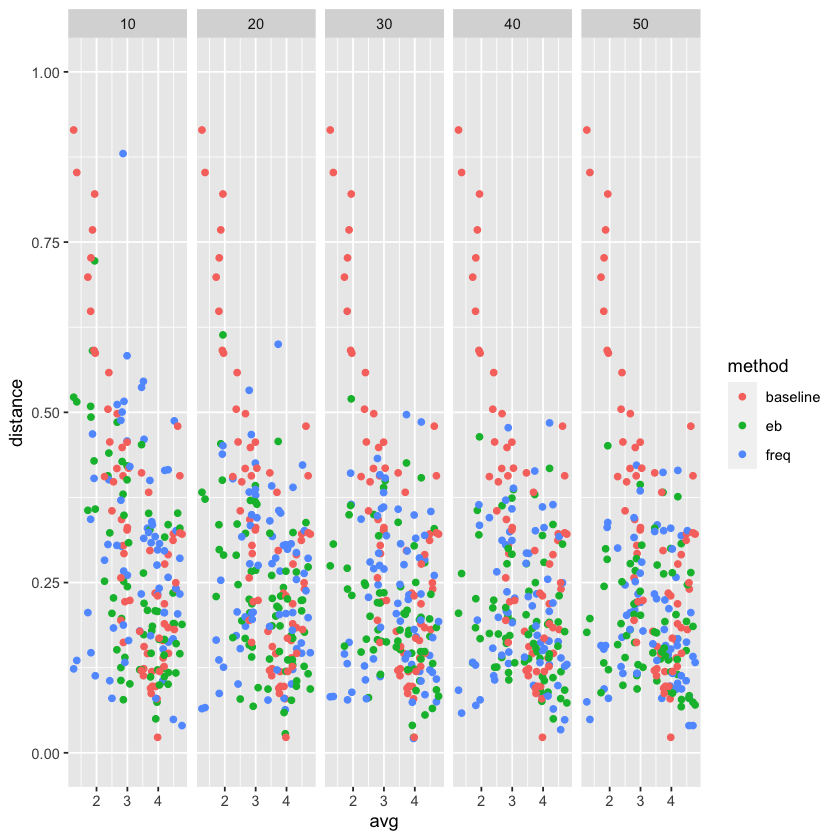

In [22]:
# Plot results

ggplot(results_df) + 
    geom_point(aes(x=avg, y=dist, color=method)) +
    facet_wrap(vars(num_train), ncol=5) +
    scale_y_continuous(name="distance", limits=c(0, 1))

In [23]:
avg_df <- results_df %>% 
           mutate(level=floor(avg*2)/2) %>%
#           mutate(level=floor(avg)) %>%
          group_by(level, method, num_train) %>%
          summarize(mean_dist=mean(dist), std = sd(dist), n=dplyr::n())

`summarise()` has grouped output by 'level', 'method'. You can override using the `.groups` argument.



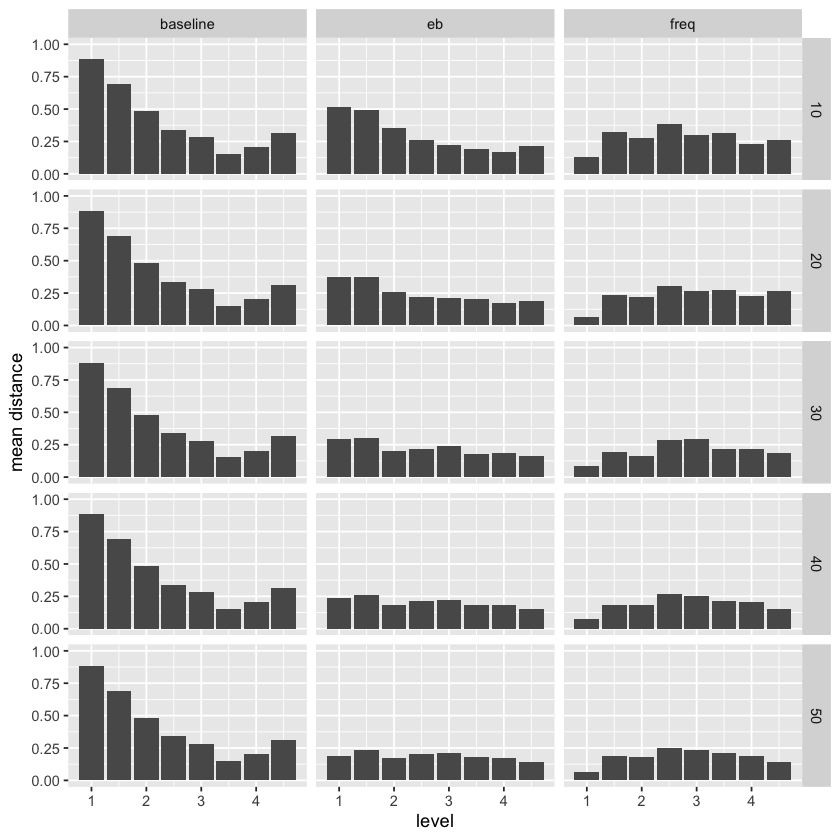

In [24]:
# Plotting averages by buckets of 0.5

ggplot(avg_df) + 
    geom_bar(aes(x=level,y=mean_dist), stat='identity') +
    facet_grid(rows = vars(num_train), cols=vars(method)) +
    scale_y_continuous(name="mean distance", limits=c(0, 1))

#### Step 3.3 Seeing how well rank from eb or frequentist settings is identified

In [25]:
library(DescTools)


Attaching package: ‘DescTools’


The following object is masked from ‘package:data.table’:

    %like%




In [26]:
test_learn_agg <- dcast(setDT(df.test), item ~ rating, fun.aggregate = length)
colnames(test_learn_agg) <- c('item', 'n1', 'n2', 'n3', 'n4', 'n5')
test_learn_agg <- test_learn_agg %>% mutate(n = n1 + n2 + n3 + n4 + n5)
test_learn_agg <- transmute(test_learn_agg, item=item, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)

In [27]:
test_subset = test_learn_agg %>% mutate(avg = n1+2*n2+3*n3+4*n4+5*n5)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



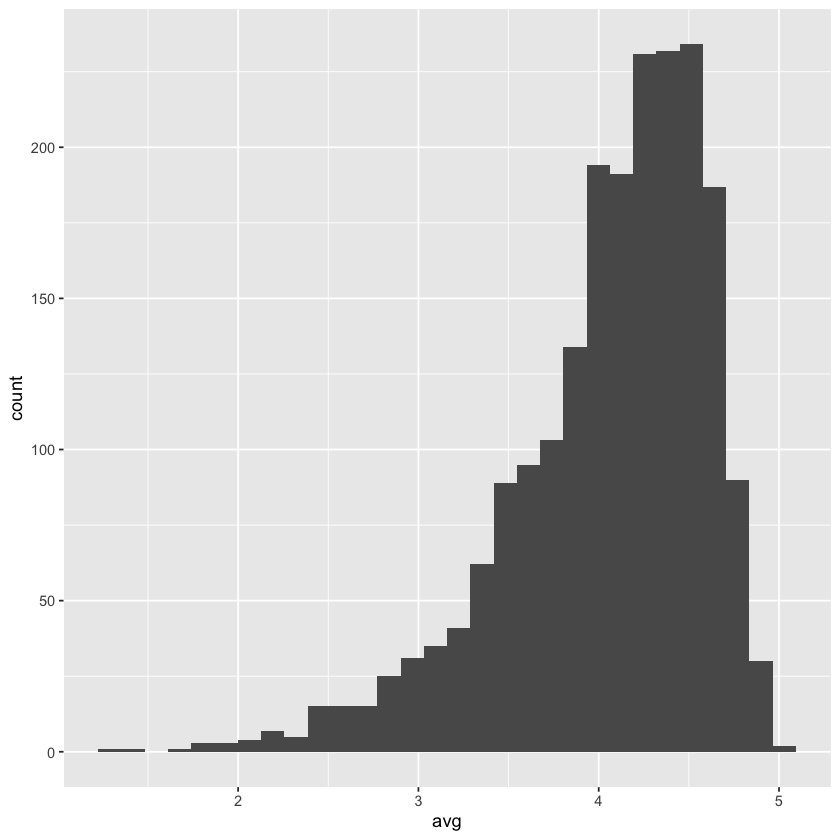

In [28]:
ggplot(test_subset, aes(x=avg)) +
    geom_histogram()

In [29]:
set.seed(1729)
test_subset <- mutate(test_subset, true_rank = dense_rank(desc(avg))) %>% sample_n(200)

In [30]:
overall_results_df = data.frame(matrix(ncol=3,nrow=0))

for (i in c(10, 20, 30, 40, 50)) {
  results_df = data.frame(matrix(ncol=5,nrow=0))
  df.test_learn_subset = group_by(df.test_learn, item) %>%
    filter(item %in% test_subset$item) %>%
    arrange(timestamp, .by_group = TRUE) %>%
    slice_head(n=i)
    
  df.test_learn_subset <- dcast(setDT(df.test_learn_subset), item ~ rating, fun.aggregate = length, drop=FALSE) %>% arrange(item)
  
  # adding missing columns
  for (j in setdiff(c("item", "1", "2", "3", "4", "5"), colnames(df.test_learn_subset))) {
    df.test_learn_subset[[j]] <- rep(0, num_eval_products)
  }
  df.test_learn_subset <- df.test_learn_subset[,c("item", "1", "2", "3", "4", "5")]
    
  colnames(df.test_learn_subset) <- c("item", "n1", "n2", "n3", "n4", "n5")
  df.test_learn_subset$n = df.test_learn_subset$"n1" + df.test_learn_subset$"n2" + df.test_learn_subset$"n3" + df.test_learn_subset$"n4" + df.test_learn_subset$"n5"
    
  df.test_learn_f <- transmute(df.test_learn_subset, item=item, avg = (n1+n2*2+n3*3+n4*4+n5*5)/n, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)
  df.test_learn_b <- mutate(df.test_learn_subset, item=item, b1 = n1 + alphas[1], b2 = n2 + alphas[2], b3 = n3 + alphas[3],
         b4 = n4 + alphas[4], b5 = n5 + alphas[5], b = n + sum(alphas))
  df.test_learn_b <- transmute(df.test_learn_b, item=item, avg = (b1+b2*2+b3*3+b4*4+b5*5)/n, b1 = b1 / b, b2 = b2 / b, b3 = b3 / b, b4 = b4 / b, b5 = b5 / b)
    
  for (id in unique(test_subset$item)) {
      dist_b = filter(df.test_learn_b, item==id) %>% select(c(b1, b2, b3, b4, b5))
      dist_f = filter(df.test_learn_f, item==id) %>% select(c(n1, n2, n3, n4, n5))
      av = filter(test_subset, item==id)$avg
      dist_eval = filter(df.test_eval, item==id) %>% select(c(n1, n2, n3, n4, n5))
      
      avg_b = dist_b$b1 + 2*dist_b$b2 + 3*dist_b$b3 + 4*dist_b$b4 + 5*dist_b$b5
      
      to_add = c(id, drop(avg_b), drop(av), i, 'eb')
      
      results_df <- rbind(results_df, to_add)
      
      avg_f = dist_f$n1 + 2*dist_f$n2 + 3*dist_f$n3 + 4*dist_f$n4 + 5*dist_f$n5
      
      to_add = c(id, drop(avg_f), drop(av), i, 'freq')
      
      results_df <- rbind(results_df, to_add)
      
  }
    
  colnames(results_df) <- c('item', 'avg_learn', 'avg_overall', 'num_train', 'method')
  print_df <- mutate(results_df, rank_learn = dense_rank(desc(avg_learn)), rank_overall = dense_rank(desc(avg_overall)))
  
  print(head(print_df))
  
  for (m in unique(results_df$method)) {
      temp_df <- filter(results_df, method==m)
      tau_b <- KendallTauB(temp_df$avg_learn, temp_df$avg_overall)
      overall_results_df <- rbind(overall_results_df, c(tau_b, i, m))
  }

}

colnames(overall_results_df) <- c('tau_b', 'num_train', 'method')

        item        avg_learn avg_overall num_train method rank_learn
1 B00K31JOIU 3.76025089317681        3.99        10     eb         28
2 B00K31JOIU              3.6        3.99        10   freq         34
3 B0024MNOGE  3.4188466466968        4.04        10     eb         40
4 B0024MNOGE              2.7        4.04        10   freq         54
5 B002RD6MV4 3.68438328284792        3.28        10     eb         31
6 B002RD6MV4              3.4        3.28        10   freq         41
  rank_overall
1           66
2           66
3           63
4           63
5          101
6          101
        item        avg_learn avg_overall num_train method rank_learn
1 B00K31JOIU 3.66117665118229        3.99        20     eb         58
2 B00K31JOIU              3.5        3.99        20   freq         67
3 B0024MNOGE 3.60617373856168        4.04        20     eb         61
4 B0024MNOGE              3.4        4.04        20   freq         73
5 B002RD6MV4  3.6886781074926        3.28        20    

In [31]:
overall_results_df

tau_b,num_train,method
<chr>,<chr>,<chr>
0.512007847695499,10,eb
0.512007847695499,10,freq
0.631172979462521,20,eb
0.631172979462521,20,freq
0.701220504954504,30,eb
0.701289321295205,30,freq
0.758158245064778,40,eb
0.758368630930026,40,freq
0.796858971397121,50,eb


### Step 3.4: Train-validate-test split to see how some prior mixture does

In [32]:
set.seed(1729)

in.val = sample(unique(df.test$item), size = 0.5*length(unique(df.test$item)))

df.val = filter(df.test, item %in% in.val)
df.test_final = filter(df.test, !(item %in% in.val))

In [33]:
#split val, test set in half

df.val_learn = group_by(df.val, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_head(n=50)
df.val_eval = group_by(df.val, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_tail(n=50)

df.test_final_learn = group_by(df.test_final, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_head(n=50)
df.test_final_eval = group_by(df.test_final, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_tail(n=50)

df.val_eval <- dcast(setDT(df.val_eval), item ~ rating, fun.aggregate = length) %>% arrange(item)
colnames(df.val_eval) <- c("item", "n1", "n2", "n3", "n4", "n5")
df.val_eval$n = df.val_eval$"n1" + df.val_eval$"n2" + df.val_eval$"n3" + df.val_eval$"n4" + df.val_eval$"n5"
df.val_eval <- transmute(df.val_eval, item=item, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)

df.test_final_eval <- dcast(setDT(df.test_final_eval), item ~ rating, fun.aggregate = length) %>% arrange(item)
colnames(df.test_final_eval) <- c("item", "n1", "n2", "n3", "n4", "n5")
df.test_final_eval$n = df.test_final_eval$"n1" + df.test_final_eval$"n2" + df.test_final_eval$"n3" + df.test_final_eval$"n4" + df.test_final_eval$"n5"
df.test_final_eval <- transmute(df.test_final_eval, item=item, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)

num_val_products = nrow(df.val_eval)
num_final_test_products = nrow(df.test_final_eval)

df.val_eval <- mutate(df.val_eval, avg = 1*n1 + 2*n2 + 3*n3 + 4*n4 + 5*n5)
df.test_final_eval <- mutate(df.test_final_eval, avg = 1*n1 + 2*n2 + 3*n3 + 4*n4 + 5*n5)

print(head(df.val_eval))

         item   n1   n2   n3   n4   n5  avg
1: 9867299434 0.10 0.12 0.12 0.24 0.42 3.76
2: B00000I1BY 0.00 0.02 0.06 0.16 0.76 4.66
3: B00000J2W7 0.00 0.00 0.02 0.22 0.76 4.74
4: B00000K2X5 0.04 0.02 0.04 0.24 0.66 4.46
5: B00001IVLY 0.02 0.00 0.02 0.08 0.88 4.80
6: B0000296O5 0.16 0.04 0.08 0.20 0.52 3.88


In [34]:
items = unique(df.test_learn$item)

mses_b = data.frame(matrix(ncol=3,nrow=0))

weights = 0:10 / 10

for (i in c(1:11)) {
    
  # convert validation into a data table
  df.test_learn_subset <- dcast(setDT(df.val_learn), item ~ rating, fun.aggregate = length, drop=FALSE) %>% arrange(item)
  
  # adding missing columns
  for (j in setdiff(c("item", "1", "2", "3", "4", "5"), colnames(df.test_learn_subset))) {
    df.test_learn_subset[[j]] <- rep(0, num_val_products)
  }
    
  df.test_learn_subset <- df.test_learn_subset[,c("item", "1", "2", "3", "4", "5")]
  
  colnames(df.test_learn_subset) <- c("item", "n1", "n2", "n3", "n4", "n5")
  df.test_learn_subset$n = df.test_learn_subset$"n1" + df.test_learn_subset$"n2" + df.test_learn_subset$"n3" + df.test_learn_subset$"n4" + df.test_learn_subset$"n5"
  
  adj_alphas = weights[i] * alphas + (1 - weights[i]) * c(0,0,0,0,0)
    
  df.test_learn_b <- mutate(df.test_learn_subset, item=item, b1 = n1 + adj_alphas[1], b2 = n2 + adj_alphas[2], b3 = n3 + adj_alphas[3],
         b4 = n4 + adj_alphas[4], b5 = n5 + adj_alphas[5], b = n + sum(adj_alphas))
  df.test_learn_b <- transmute(df.test_learn_b, item=item, avg = (b1+b2*2+b3*3+b4*4+b5*5)/n, b1 = b1 / b, b2 = b2 / b, b3 = b3 / b, b4 = b4 / b, b5 = b5 / b)
    
  # print(rowSums((select(df.test_learn_b, c(b1,b2,b3,b4,b5)) - select(df.val_eval, c(n1,n2,n3,n4,n5)))^2))
  dists = rowSums((select(df.test_learn_b, c(b1,b2,b3,b4,b5)) - select(df.val_eval, c(n1,n2,n3,n4,n5)))^2)
  mse_b = mean(dists)  
  max_diff_b = max(dists)
  to_add <- c(weights[i], mse_b, max_diff_b)
    
  mses_b <- rbind(mses_b, to_add)
    
}

colnames(mses_b) <- c('weight on prior', 'mean dist', 'max dist')
mses_b

weight on prior,mean dist,max dist
<dbl>,<dbl>,<dbl>
0.0,0.04097649,0.3064000
0.1,0.03964379,0.2963712
0.2,0.03853498,0.2994083
0.3,0.03761773,0.3029486
0.4,0.03686483,0.3063798
0.5,0.03625330,0.3097033
0.6,0.03576363,0.3129210
0.7,0.03537921,0.3160356
0.8,0.03508586,0.3190498


The value that minimizes the maximum distance between a predicted distribution and the true distribution for a user is $\eta = 0.1$. Let's see how this does when we stratify across time and average rating quartiles:

In [35]:
alphas_mix = 0.1 * alphas + (1 - 0.1)*c(0,0,0,0,0)

In [36]:
test_learn_agg <- dcast(setDT(df.test_final), item ~ rating, fun.aggregate = length)
colnames(test_learn_agg) <- c('item', 'n1', 'n2', 'n3', 'n4', 'n5')
test_learn_agg <- test_learn_agg %>% mutate(n = n1 + n2 + n3 + n4 + n5)
test_learn_agg <- transmute(test_learn_agg, item=item, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



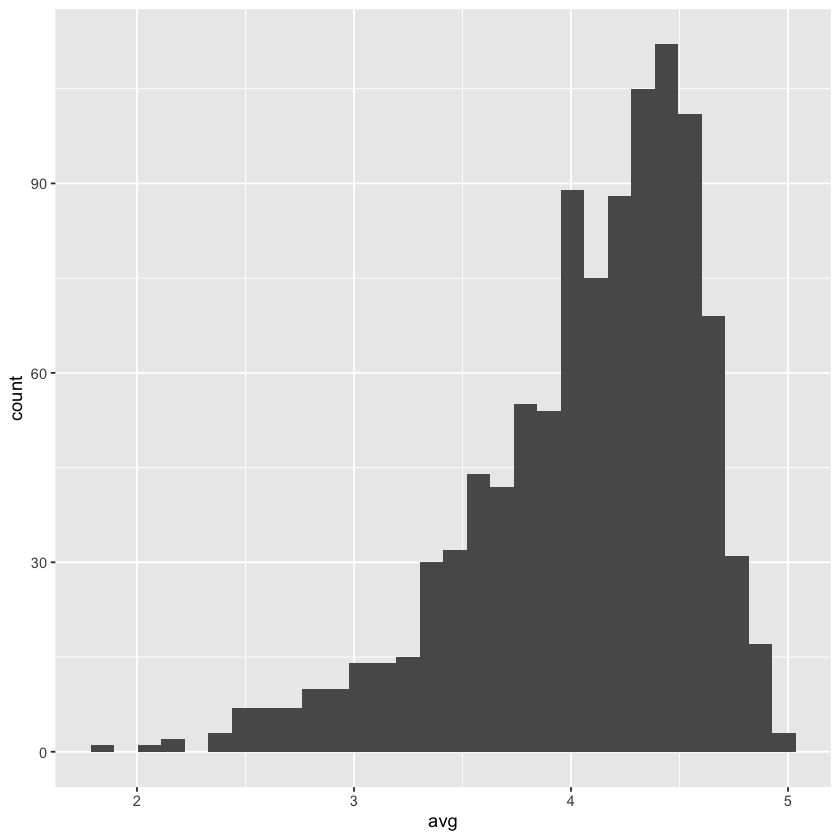

In [37]:
test_subset = test_learn_agg %>% mutate(avg = (n1+2*n2+3*n3+4*n4+5*n5))
ggplot(test_subset, aes(x=avg)) +
    geom_histogram()

In [38]:
set.seed(1729)

num_prods = 20

test_subset_1 <- test_subset %>% filter(!duplicated(item)) %>% filter(avg <= 2) 
test_subset_1 <- test_subset_1 %>% sample_n(min(num_prods, nrow(test_subset_1))) 
test_subset_2 <- test_subset %>% filter(!duplicated(item)) %>% filter(avg <= 3, avg > 2) 
test_subset_2 <- test_subset_2 %>% sample_n(min(num_prods, nrow(test_subset_2)))
test_subset_3 <- test_subset %>% filter(!duplicated(item)) %>% filter(avg <= 4, avg > 3) 
test_subset_3 <- test_subset_3 %>% sample_n(min(num_prods, nrow(test_subset_3)))
test_subset_4 <- test_subset %>% filter(!duplicated(item)) %>% filter(avg > 4) 
test_subset_4 <- test_subset_4 %>% sample_n(min(num_prods, nrow(test_subset_4)))

# this is the list of items, along with their average score, that we will test

test_subset <- rbind(test_subset_1, test_subset_2, test_subset_3, test_subset_4)
print(nrow(test_subset))

[1] 61


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



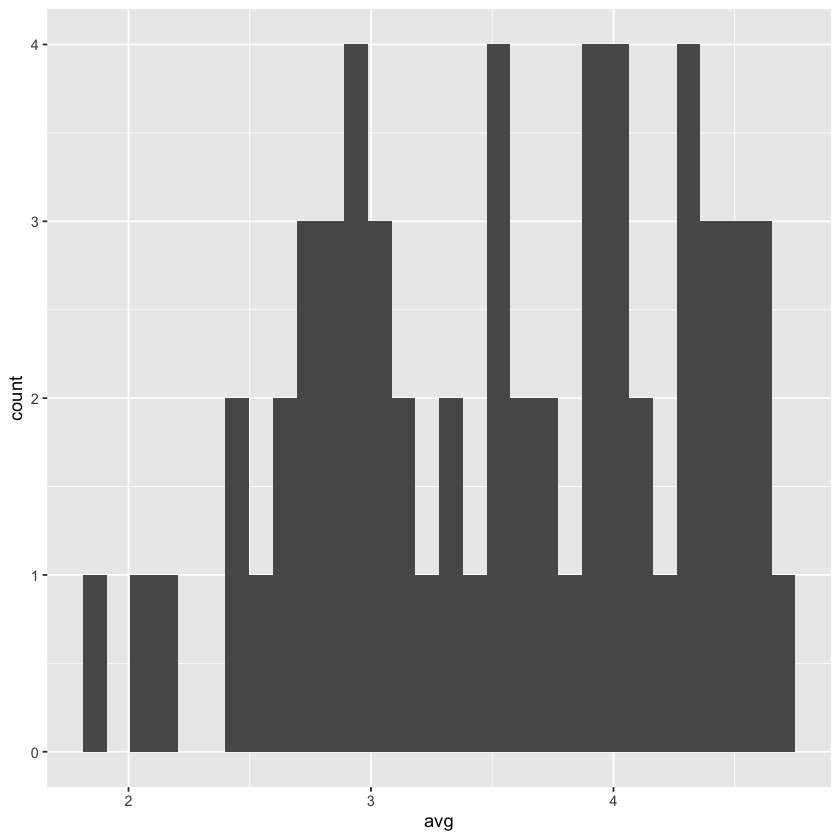

In [39]:
ggplot(test_subset, aes(x=avg)) +
    geom_histogram()

In [40]:
results_df = data.frame(matrix(ncol=5,nrow=0))

for (i in c(1, 3, 5, 10, 50)) {
  df.test_learn_subset = group_by(df.test_final_learn, item) %>%
    filter(item %in% test_subset$item) %>%
    arrange(timestamp, .by_group = TRUE) %>%
    slice_head(n=i)
    
  df.test_learn_subset <- dcast(setDT(df.test_learn_subset), item ~ rating, fun.aggregate = length, drop=FALSE) %>% arrange(item)
  
  # adding missing columns
  for (j in setdiff(c("item", "1", "2", "3", "4", "5"), colnames(df.test_learn_subset))) {
    df.test_learn_subset[[j]] <- rep(0, num_eval_products)
  }
  df.test_learn_subset <- df.test_learn_subset[,c("item", "1", "2", "3", "4", "5")]
    
  colnames(df.test_learn_subset) <- c("item", "n1", "n2", "n3", "n4", "n5")
  df.test_learn_subset$n = df.test_learn_subset$"n1" + df.test_learn_subset$"n2" + df.test_learn_subset$"n3" + df.test_learn_subset$"n4" + df.test_learn_subset$"n5"
    
  df.test_learn_f <- transmute(df.test_learn_subset, item=item, avg = (n1+n2*2+n3*3+n4*4+n5*5)/n, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)
  df.test_learn_b <- mutate(df.test_learn_subset, item=item, b1 = n1 + alphas[1], b2 = n2 + alphas[2], b3 = n3 + alphas[3],
         b4 = n4 + alphas[4], b5 = n5 + alphas[5], b = n + sum(alphas))
  df.test_learn_b <- transmute(df.test_learn_b, item=item, avg = (b1+b2*2+b3*3+b4*4+b5*5)/n, b1 = b1 / b, b2 = b2 / b, b3 = b3 / b, b4 = b4 / b, b5 = b5 / b)
  df.test_learn_p <- mutate(df.test_learn_subset, item=item, b1 = n1 + alphas_mix[1], b2 = n2 + alphas_mix[2], b3 = n3 + alphas_mix[3],
         b4 = n4 + alphas_mix[4], b5 = n5 + alphas_mix[5], b = n + sum(alphas_mix))
  df.test_learn_p <- transmute(df.test_learn_p, item=item, avg = (b1+b2*2+b3*3+b4*4+b5*5)/n, b1 = b1 / b, b2 = b2 / b, b3 = b3 / b, b4 = b4 / b, b5 = b5 / b)
    
  for (id in unique(test_subset$item)) {
      dist_b = filter(df.test_learn_b, item==id) %>% select(c(b1, b2, b3, b4, b5))
      dist_f = filter(df.test_learn_f, item==id) %>% select(c(n1, n2, n3, n4, n5))
      dist_p = filter(df.test_learn_p, item==id) %>% select(c(b1, b2, b3, b4, b5))
      av = filter(test_subset, item==id)$avg
      dist_eval = filter(df.test_final_eval, item==id) %>% select(c(n1, n2, n3, n4, n5))
      
      to_add = c(id, sqrt(sum((dist_eval-dist_b)^2)), drop(av), i, 'eb')
      
      results_df <- rbind(results_df, to_add)
      
      to_add = c(id, sqrt(sum((dist_eval-dist_f)^2)), drop(av), i, 'freq')
      
      results_df <- rbind(results_df, to_add)
      
      to_add = c(id, sqrt(sum((dist_eval-alphas_b)^2)), drop(av), i, 'baseline')
      
      results_df <- rbind(results_df, to_add)
      
      to_add = c(id, sqrt(sum((dist_eval-dist_p)^2)), drop(av), i, 'mixed')
      
      results_df <- rbind(results_df, to_add)
      
  }

}

colnames(results_df) <- c('item', 'dist', 'avg', 'num_train', 'method')

In [41]:
results_df$dist <- as.numeric(results_df$dist)
results_df$avg <- as.numeric(results_df$avg)
results_df$num_train <- as.numeric(results_df$num_train)

Warning message:
“Removed 19 rows containing missing values (geom_point).”


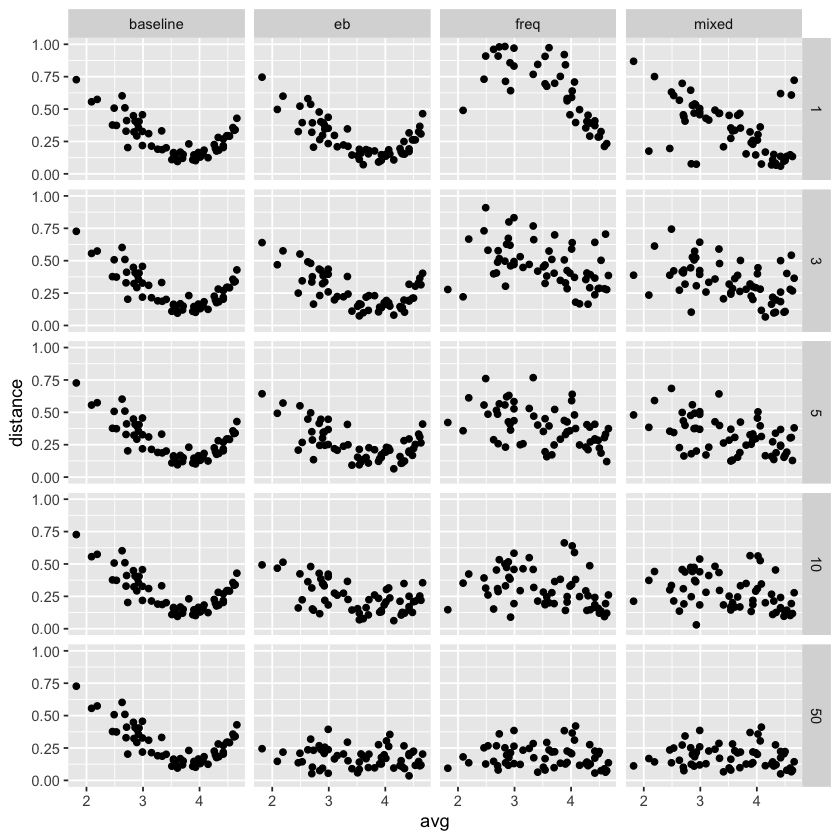

In [42]:
ggplot(results_df) + 
    geom_point(aes(x=avg, y=dist)) +
    facet_grid(rows = vars(num_train), cols=vars(method)) +
    scale_y_continuous(name="distance", limits=c(0, 1))

In [43]:
avg_df <- results_df %>% 
           mutate(level=floor(avg*2)/2) %>%
#           mutate(level=floor(avg)) %>%
          group_by(level, method, num_train) %>%
          summarize(mean_dist=mean(dist), std = sd(dist), n=dplyr::n())

`summarise()` has grouped output by 'level', 'method'. You can override using the `.groups` argument.



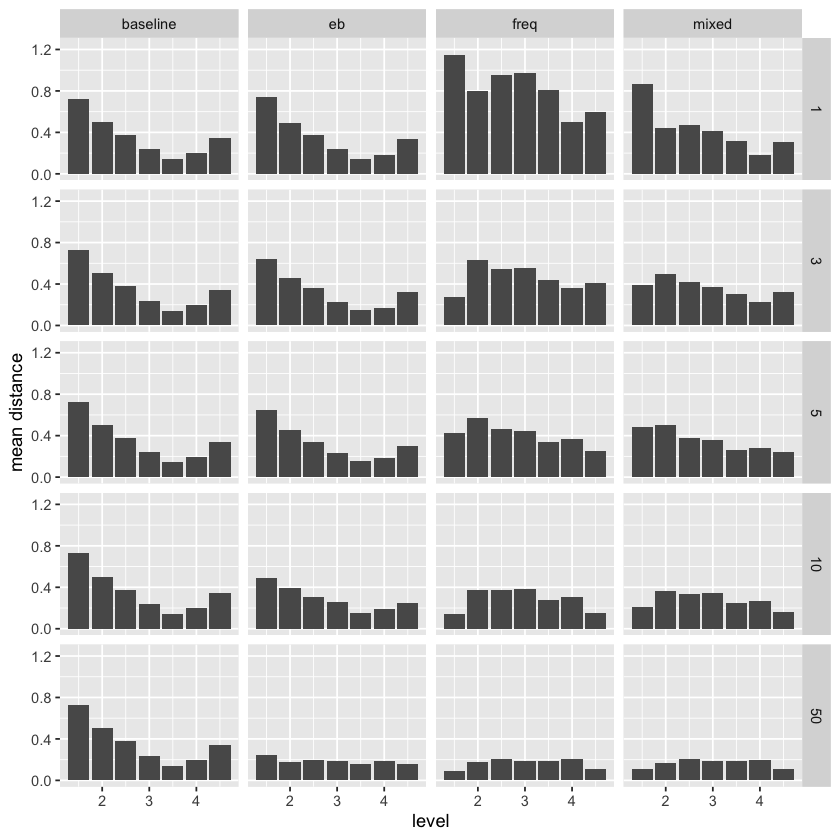

In [44]:
# Plotting averages by buckets of 0.5

ggplot(avg_df) + 
    geom_bar(aes(x=level,y=mean_dist),stat='identity') +
    facet_grid(rows = vars(num_train), cols=vars(method)) +
    scale_y_continuous(name="mean distance", limits=c(0, 1.25))

### 3.5: Plotting all data points and all mixture weights

In [54]:
set.seed(1729)

in.val = sample(unique(df.test$item), size = 0.5*length(unique(df.test$item)))

df.val = filter(df.test, item %in% in.val)
df.test_final = filter(df.test, !(item %in% in.val))

In [55]:
#split val, test set in half

df.val_learn = group_by(df.val, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_head(n=50)
df.val_eval = group_by(df.val, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_tail(n=50)

df.test_final_learn = group_by(df.test_final, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_head(n=50)
df.test_final_eval = group_by(df.test_final, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_tail(n=50)

df.val_eval <- dcast(setDT(df.val_eval), item ~ rating, fun.aggregate = length) %>% arrange(item)
colnames(df.val_eval) <- c("item", "n1", "n2", "n3", "n4", "n5")
df.val_eval$n = df.val_eval$"n1" + df.val_eval$"n2" + df.val_eval$"n3" + df.val_eval$"n4" + df.val_eval$"n5"
df.val_eval <- transmute(df.val_eval, item=item, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)

df.test_final_eval <- dcast(setDT(df.test_final_eval), item ~ rating, fun.aggregate = length) %>% arrange(item)
colnames(df.test_final_eval) <- c("item", "n1", "n2", "n3", "n4", "n5")
df.test_final_eval$n = df.test_final_eval$"n1" + df.test_final_eval$"n2" + df.test_final_eval$"n3" + df.test_final_eval$"n4" + df.test_final_eval$"n5"
df.test_final_eval <- transmute(df.test_final_eval, item=item, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)

num_val_products = nrow(df.val_eval)
num_final_test_products = nrow(df.test_final_eval)

df.val_eval <- mutate(df.val_eval, avg = 1*n1 + 2*n2 + 3*n3 + 4*n4 + 5*n5)
df.test_final_eval <- mutate(df.test_final_eval, avg = 1*n1 + 2*n2 + 3*n3 + 4*n4 + 5*n5)

In [56]:
# comment out this line if you want to use validation set instead of test set

df.val_learn <- df.test_learn
df.val_eval <- df.test_eval
df.val_eval <- mutate(df.val_eval, avg = (n1 + 2*n2 + 3*n3 + 4*n4 + 5*n5)/(n1 + n2 + n3 + n4 + n5))

In [59]:
items = unique(df.test_learn$item)

weights = 0:10 / 10

val_results_df <- data.frame(matrix(ncol=6,nrow=0))

for (i in c(1:11)) {

  for (k in c(1,3,5,10,20,50)) {
  
    df.test_learn_subset = group_by(df.val_learn, item) %>%
      arrange(timestamp, .by_group = TRUE) %>%
      slice_head(n=k)
  
      # convert validation into a data table
    df.test_learn_subset <- dcast(setDT(df.test_learn_subset), item ~ rating, fun.aggregate = length, drop=FALSE) %>% arrange(item)

      # adding missing columns
    for (j in setdiff(c("item", "1", "2", "3", "4", "5"), colnames(df.test_learn_subset))) {
      df.test_learn_subset[[j]] <- rep(0, num_val_products)
      }

    df.test_learn_subset <- df.test_learn_subset[,c("item", "1", "2", "3", "4", "5")]

    colnames(df.test_learn_subset) <- c("item", "n1", "n2", "n3", "n4", "n5")
    df.test_learn_subset$n = df.test_learn_subset$"n1" + df.test_learn_subset$"n2" + df.test_learn_subset$"n3" + df.test_learn_subset$"n4" + df.test_learn_subset$"n5"

    adj_alphas = weights[i] * alphas + (1 - weights[i]) * c(1,1,1,1,1)

    df.test_learn_b <- mutate(df.test_learn_subset, item=item, b1 = n1 + adj_alphas[1], b2 = n2 + adj_alphas[2], b3 = n3 + adj_alphas[3],
             b4 = n4 + adj_alphas[4], b5 = n5 + adj_alphas[5], b = n + sum(adj_alphas))
    df.test_learn_b <- transmute(df.test_learn_b, item=item, b1 = (b1-1) / (b-5), b2 = (b2-1) / (b-5), b3 = (b3-1) / (b-5), b4 = (b4-1) / (b-5), b5 = (b5-1) / (b-5))
    df.test_learn_b <- transmute(df.test_learn_b, item=item, avg = (b1+b2*2+b3*3+b4*4+b5*5), b1 = b1, b2 = b2, b3 = b3, b4 = b4, b5 = b5)

    dists = rowSums((select(df.test_learn_b, c(b1,b2,b3,b4,b5)) - select(df.val_eval, c(n1,n2,n3,n4,n5)))^2)
    
    eb_est <- df.test_learn_b$avg

    to_add = tibble(df.test_learn_b$item, df.val_eval$avg, dists, weights[i], k, eb_est)

    val_results_df <- rbind(val_results_df, to_add)
    
  }
    
}

colnames(val_results_df) <- c('item', 'avg', 'distance', 'eta', 'num_train', 'est')
head(val_results_df)

item,avg,distance,eta,num_train,est
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6050036071,3.62,0.9192,0,1,4
9625990674,4.32,0.1976,0,1,5
9629971372,3.66,1.1832,0,1,3
9867299434,3.76,0.4328,0,1,5
B00000DMAR,4.14,0.1240,0,1,5
B00000DMB3,4.98,0.0008,0,1,5


Warning message:
“Removed 96 rows containing missing values (geom_hex).”


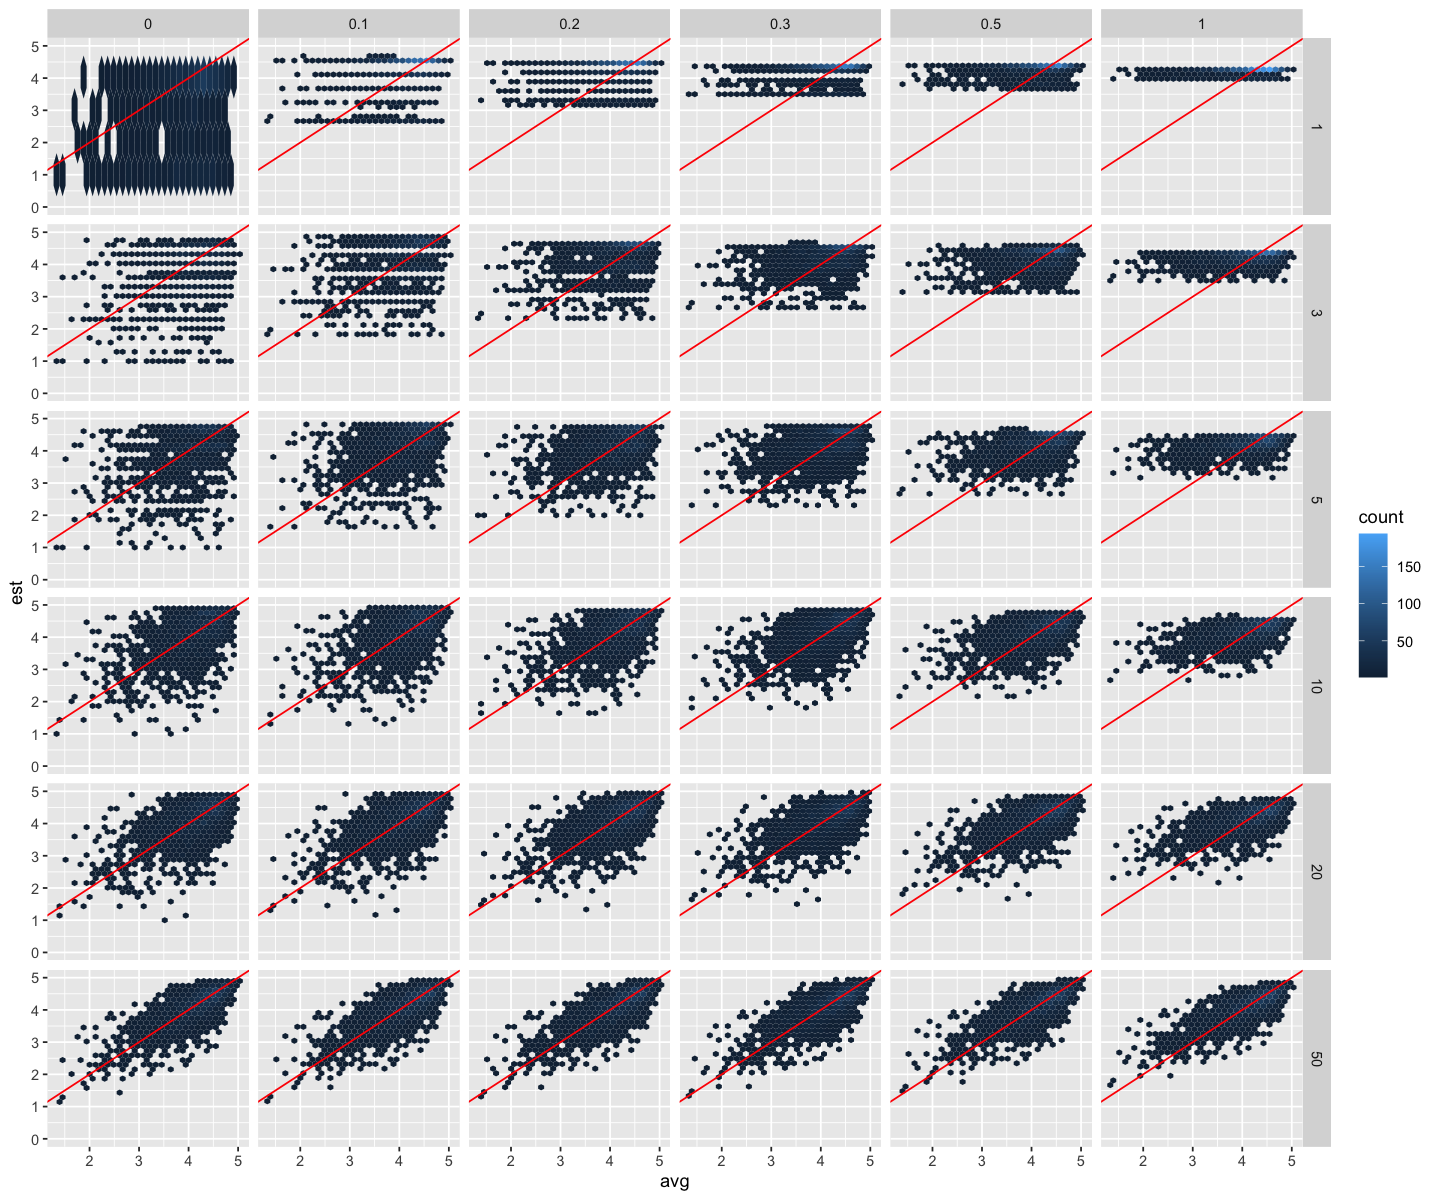

In [64]:
ggplot(filter(val_results_df, eta %in% c(0,0.1,0.2,0.3,0.5,1))) + 
    geom_hex(aes(x=avg, y=est)) +
    geom_abline(color='red')+
    facet_grid(rows = vars(num_train), cols=vars(eta)) +
    scale_y_continuous(name="est", limits=c(0, 5))

In [63]:
options(repr.plot.width=12, repr.plot.height=10)

Warning message:
“Removed 277 rows containing missing values (geom_hex).”


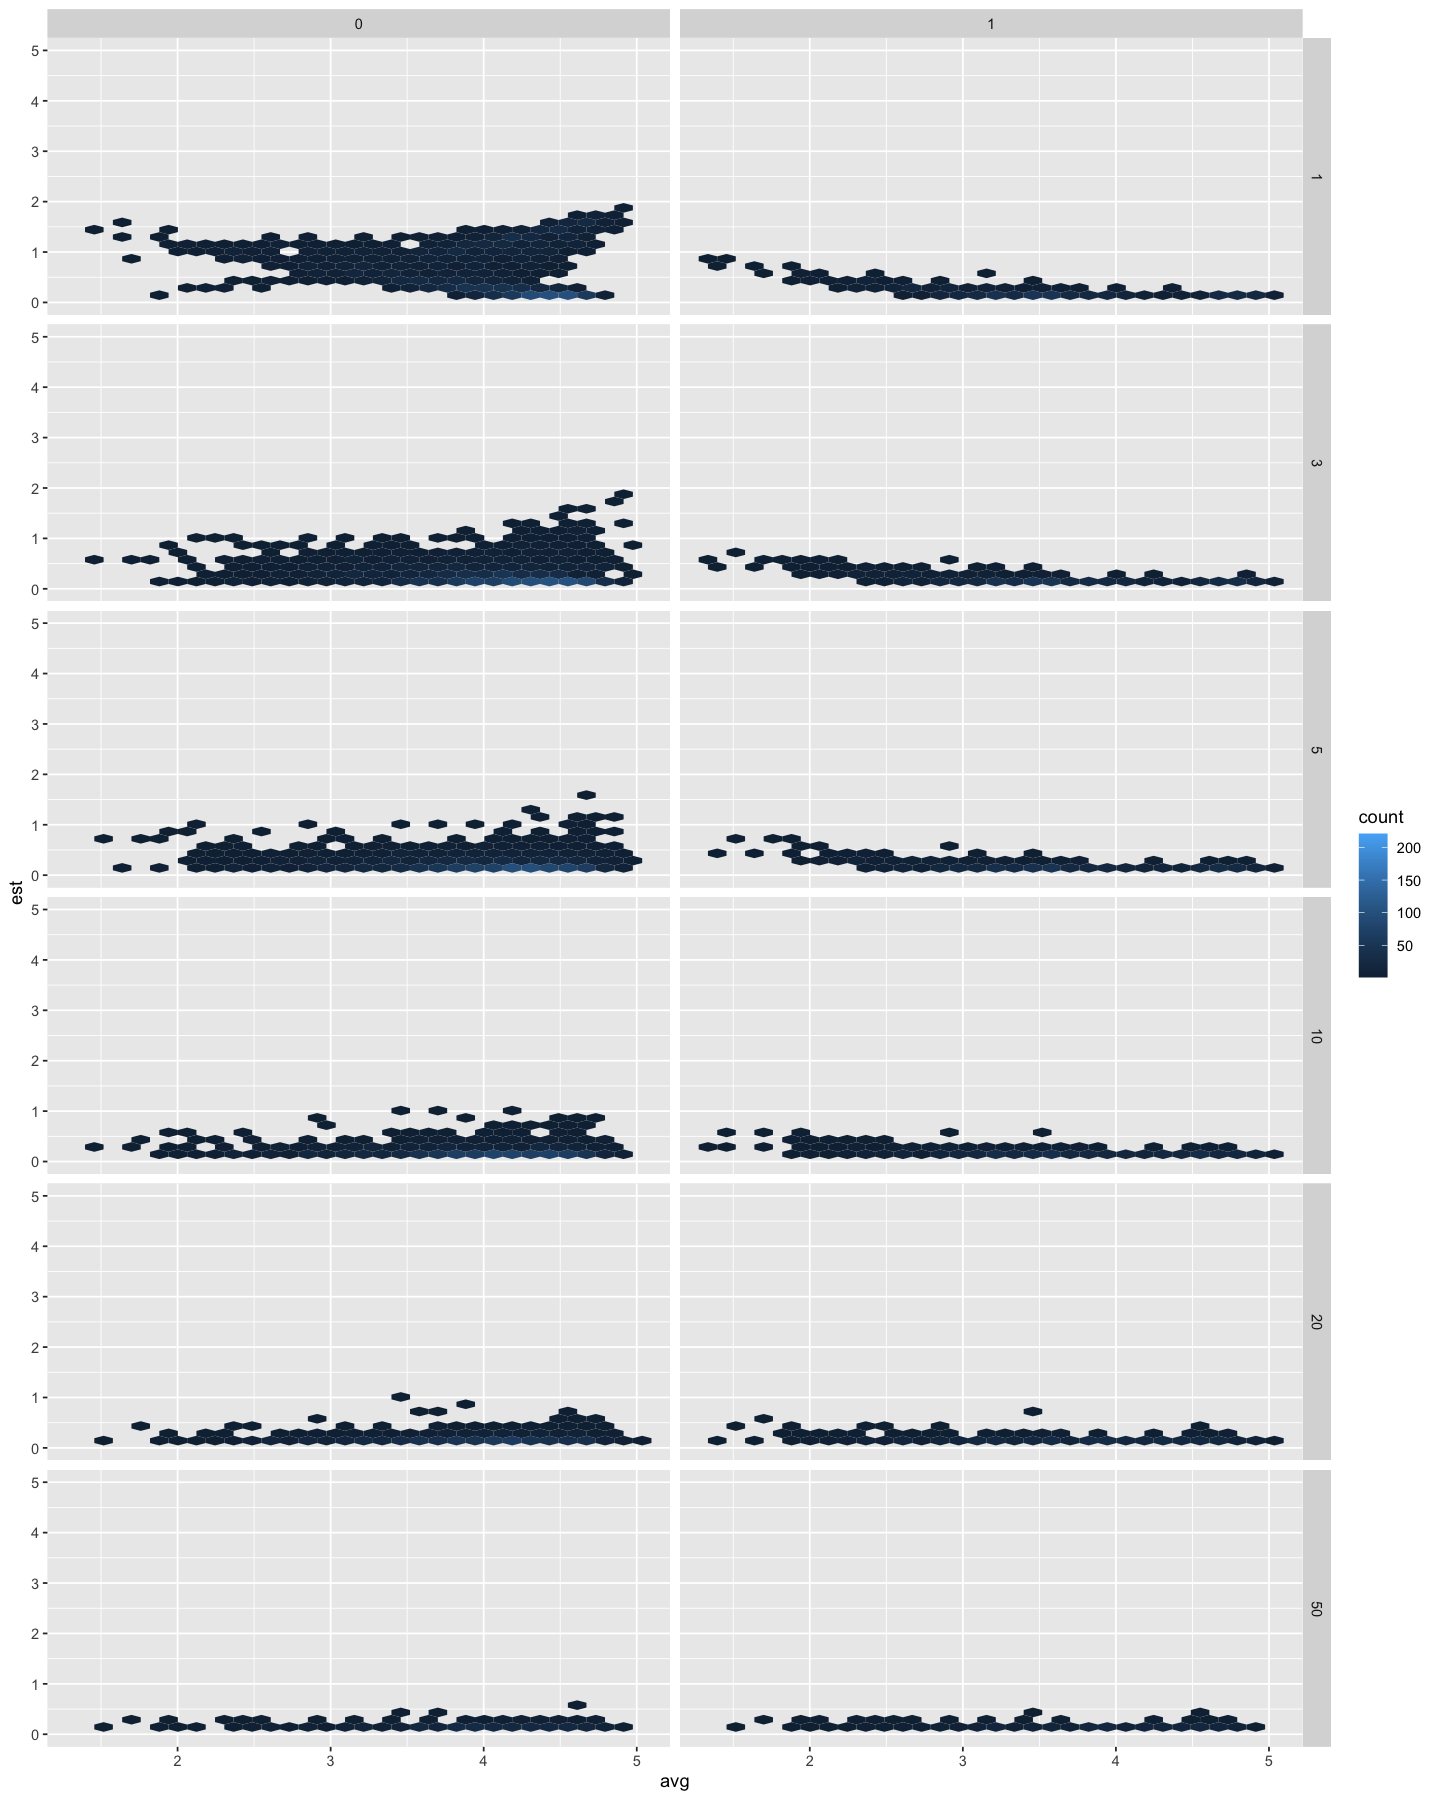

In [62]:
ggplot(filter(val_results_df, eta %in% c(0,1))) + 
    geom_hex(aes(x=avg, y=distance)) +
    facet_grid(rows = vars(num_train), cols=vars(eta)) +
    scale_y_continuous(name="est", limits=c(0, 5))

In [96]:
filter(val_results_df, eta==0, num_train==1)

item,avg,distance,eta,num_train,est
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6050036071,3.62,0.10808889,0,1,3.166667
9625990674,4.32,0.11982222,0,1,3.333333
9629971372,3.66,0.20542222,0,1,3.000000
9867299434,3.76,0.02168889,0,1,3.333333
B00000DMAR,4.14,0.17955556,0,1,3.333333
B00000DMB3,4.98,0.52302222,0,1,3.333333
B00000F1GM,4.82,0.56782222,0,1,3.166667
B00000I1BF,4.72,0.30435556,0,1,3.333333
B00000I1BY,4.66,0.24275556,0,1,3.333333
